In [1267]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ppscore as ps
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
import pandas_datareader
from datetime import date

# In this notebook, we will use Logistic Regression techniques to perform a prediction on whether a stock will move up or down on the next day

## Load in initial datasets using pandas_datareader with yahoo finance

In [1268]:
# Load in intitial datasets
ticker = 'aapl'
startdate = '2007-06-29'
aapl = pandas_datareader.DataReader(ticker.lower(), 'yahoo', start=startdate, end = date.today().strftime("%Y-%m-%d"))
aapl.reset_index(inplace=True)

ticker = '^vix'
startdate = '2007-06-29'
vix = pandas_datareader.DataReader(ticker.lower(), 'yahoo', start=startdate, end = date.today().strftime("%Y-%m-%d"))
vix.reset_index(inplace=True)

## Data cleaning

In [1269]:
vix.drop(['Volume', 'High', 'Low', 'Close', 'Open', 'Volume'], axis=1, inplace=True)
vix.rename(columns={'Adj Close': 'VIX_AdjClose'}, inplace=True)

In [1270]:
# Get the means of columns with any missing values 
# Could make this a mean within 10 values surrounding possibly
def get_missing_values(df):
    values = {}
    for feat in df.columns:
        if df[feat].isna().any():
            values[feat] = round(df[feat].mean(),3)
    return values

values = get_missing_values(aapl)
values

{}

In [1271]:
len(vix)

3885

In [1272]:
len(aapl)

3885

<AxesSubplot:>

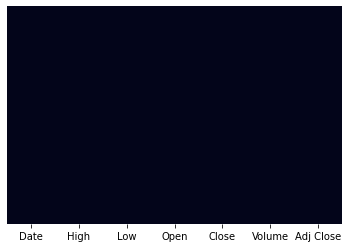

In [1273]:
# Fill empty values and display heatmap
aapl.fillna(value=values, inplace=True)
sns.heatmap(aapl.isnull(), yticklabels=False, cbar=False)

<AxesSubplot:>

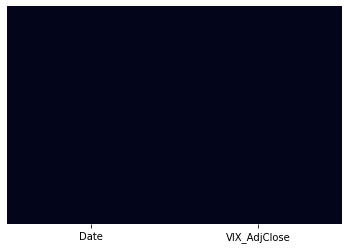

In [1274]:
# Fill empty values and display heatmap
vix.fillna(value=values, inplace=True)
sns.heatmap(vix.isnull(), yticklabels=False, cbar=False)

In [1275]:
# Summary of columns with null values 
Sum = aapl.isnull().sum()
Percentage = (aapl.isnull().sum()/aapl.isnull().count())

pd.concat([Sum,Percentage], axis =1, keys= ['Sum', 'Percentage'])

,Sum,Percentage
Date,0,0.0
High,0,0.0
Low,0,0.0
Open,0,0.0
Close,0,0.0
Volume,0,0.0
Adj Close,0,0.0


In [1276]:
# Turn date into datetime
aapl['Date'] = pd.to_datetime(aapl.Date)
vix['Date'] = pd.to_datetime(vix.Date)
df = aapl.merge(vix, how='inner', on=['Date'])

In [1277]:
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,VIX_AdjClose
0,2007-06-29,4.428571,4.324643,4.356071,4.358571,1.137842e+09,3.715323,16.23
1,2007-07-02,4.360357,4.260714,4.323214,4.330714,9.948624e+08,3.691579,15.40
2,2007-07-03,4.550000,4.339286,4.357143,4.541786,1.162482e+09,3.871499,14.92
3,2007-07-05,4.748929,4.596071,4.600000,4.741071,1.453052e+09,4.041373,15.48
4,2007-07-06,4.762143,4.657143,4.754643,4.725000,8.746948e+08,4.027675,14.72


In [1278]:
df.describe()

,High,Low,Open,Close,Volume,Adj Close,VIX_AdjClose
count,3885.000000,3885.000000,3885.000000,3885.000000,3.885000e+03,3885.000000,3885.000000
mean,43.835257,42.868340,43.347518,43.371359,3.612166e+08,41.685838,20.528950
std,46.733883,45.592858,46.150335,46.188701,3.594166e+08,46.429761,9.406937
min,2.928571,2.792857,2.835357,2.792857,3.519590e+07,2.380682,9.140000
25%,12.491071,12.314286,12.375000,12.383929,1.108432e+08,10.556284,14.120000
50%,25.712500,25.299999,25.482500,25.467501,2.165380e+08,23.212036,18.040001
75%,49.294998,48.400002,48.834999,48.772499,4.794496e+08,47.338932,24.020000
max,182.940002,179.119995,182.630005,182.009995,3.372970e+09,180.959732,82.690002


In [1279]:
df = df[['Date', 'Adj Close', 'VIX_AdjClose']].copy()
df.rename(columns={'Adj Close': 'Close'}, inplace=True)
df

,Date,Close,VIX_AdjClose
0,2007-06-29,3.715323,16.230000
1,2007-07-02,3.691579,15.400000
2,2007-07-03,3.871499,14.920000
3,2007-07-05,4.041373,15.480000
4,2007-07-06,4.027675,14.720000
...,...,...,...
3880,2022-11-25,148.110001,20.500000
3881,2022-11-28,144.220001,22.209999
3882,2022-11-29,141.169998,21.889999
3883,2022-11-30,148.029999,20.580000


In [1280]:
# Get series' of 3 weeks days ago days of lagging prices for logistic regression
for i in range(1, 31):
    df['Trailing ' + str(i) + ' day(s)'] = df['Close'].shift(i)

In [1281]:
df

,Date,Close,VIX_AdjClose,Trailing 1 day(s),Trailing 2 day(s),Trailing 3 day(s),Trailing 4 day(s),Trailing 5 day(s),Trailing 6 day(s),Trailing 7 day(s),...,Trailing 21 day(s),Trailing 22 day(s),Trailing 23 day(s),Trailing 24 day(s),Trailing 25 day(s),Trailing 26 day(s),Trailing 27 day(s),Trailing 28 day(s),Trailing 29 day(s),Trailing 30 day(s)
0,2007-06-29,3.715323,16.230000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2007-07-02,3.691579,15.400000,3.715323,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2007-07-03,3.871499,14.920000,3.691579,3.715323,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2007-07-05,4.041373,15.480000,3.871499,3.691579,3.715323,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2007-07-06,4.027675,14.720000,4.041373,3.871499,3.691579,3.715323,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3880,2022-11-25,148.110001,20.500000,151.070007,150.179993,148.009995,151.289993,150.720001,148.789993,150.039993,...,149.102661,152.087708,149.202484,147.026108,143.152527,143.621750,143.511932,142.174164,138.150833,142.753204
3881,2022-11-28,144.220001,22.209999,148.110001,151.070007,150.179993,148.009995,151.289993,150.720001,148.789993,...,144.560196,149.102661,152.087708,149.202484,147.026108,143.152527,143.621750,143.511932,142.174164,138.150833
3882,2022-11-29,141.169998,21.889999,144.220001,148.110001,151.070007,150.179993,148.009995,151.289993,150.720001,...,155.482086,144.560196,149.102661,152.087708,149.202484,147.026108,143.152527,143.621750,143.511932,142.174164
3883,2022-11-30,148.029999,20.580000,141.169998,144.220001,148.110001,151.070007,150.179993,148.009995,151.289993,...,153.086044,155.482086,144.560196,149.102661,152.087708,149.202484,147.026108,143.152527,143.621750,143.511932


In [1282]:
# Prev change is today's change
df['Prev Change'] = (((df['Close'].shift(1)) / (df['Close']) - 1) * 100).fillna(0)
# NextDayChange is tomorrow's change
df['NextDayChange'] = (((df['Close'].shift(-1)) / (df['Close']) - 1) * 100).fillna(0)
df

,Date,Close,VIX_AdjClose,Trailing 1 day(s),Trailing 2 day(s),Trailing 3 day(s),Trailing 4 day(s),Trailing 5 day(s),Trailing 6 day(s),Trailing 7 day(s),...,Trailing 23 day(s),Trailing 24 day(s),Trailing 25 day(s),Trailing 26 day(s),Trailing 27 day(s),Trailing 28 day(s),Trailing 29 day(s),Trailing 30 day(s),Prev Change,NextDayChange
0,2007-06-29,3.715323,16.230000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,-0.639092
1,2007-07-02,3.691579,15.400000,3.715323,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.643203,4.873787
2,2007-07-03,3.871499,14.920000,3.691579,3.715323,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.647289,4.387821
3,2007-07-05,4.041373,15.480000,3.871499,3.691579,3.715323,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.203384,-0.338958
4,2007-07-06,4.027675,14.720000,4.041373,3.871499,3.691579,3.715323,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.340111,-1.489029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3880,2022-11-25,148.110001,20.500000,151.070007,150.179993,148.009995,151.289993,150.720001,148.789993,150.039993,...,149.202484,147.026108,143.152527,143.621750,143.511932,142.174164,138.150833,142.753204,1.998519,-2.626426
3881,2022-11-28,144.220001,22.209999,148.110001,151.070007,150.179993,148.009995,151.289993,150.720001,148.789993,...,152.087708,149.202484,147.026108,143.152527,143.621750,143.511932,142.174164,138.150833,2.697268,-2.114827
3882,2022-11-29,141.169998,21.889999,144.220001,148.110001,151.070007,150.179993,148.009995,151.289993,150.720001,...,149.102661,152.087708,149.202484,147.026108,143.152527,143.621750,143.511932,142.174164,2.160518,4.859390
3883,2022-11-30,148.029999,20.580000,141.169998,144.220001,148.110001,151.070007,150.179993,148.009995,151.289993,...,144.560196,149.102661,152.087708,149.202484,147.026108,143.152527,143.621750,143.511932,-4.634196,0.189150


In [1283]:
# 1 represents up, 0 represents down 
df['Direction'] = [1 if i > 0 else 0 for i in df['NextDayChange']]
# Shift the direction back 1, so that Direction in a given row corresponds to where it is going tomorrow
df['Direction'] = df['Direction'].shift(-1)

df.tail()

,Date,Close,VIX_AdjClose,Trailing 1 day(s),Trailing 2 day(s),Trailing 3 day(s),Trailing 4 day(s),Trailing 5 day(s),Trailing 6 day(s),Trailing 7 day(s),...,Trailing 24 day(s),Trailing 25 day(s),Trailing 26 day(s),Trailing 27 day(s),Trailing 28 day(s),Trailing 29 day(s),Trailing 30 day(s),Prev Change,NextDayChange,Direction
3880,2022-11-25,148.110001,20.500000,151.070007,150.179993,148.009995,151.289993,150.720001,148.789993,150.039993,...,147.026108,143.152527,143.621750,143.511932,142.174164,138.150833,142.753204,1.998519,-2.626426,0.0
3881,2022-11-28,144.220001,22.209999,148.110001,151.070007,150.179993,148.009995,151.289993,150.720001,148.789993,...,149.202484,147.026108,143.152527,143.621750,143.511932,142.174164,138.150833,2.697268,-2.114827,1.0
3882,2022-11-29,141.169998,21.889999,144.220001,148.110001,151.070007,150.179993,148.009995,151.289993,150.720001,...,152.087708,149.202484,147.026108,143.152527,143.621750,143.511932,142.174164,2.160518,4.859390,1.0
3883,2022-11-30,148.029999,20.580000,141.169998,144.220001,148.110001,151.070007,150.179993,148.009995,151.289993,...,149.102661,152.087708,149.202484,147.026108,143.152527,143.621750,143.511932,-4.634196,0.189150,0.0
3884,2022-12-01,148.309998,19.840000,148.029999,141.169998,144.220001,148.110001,151.070007,150.179993,148.009995,...,144.560196,149.102661,152.087708,149.202484,147.026108,143.152527,143.621750,-0.188793,0.000000,NaN


Text(0.5, 1.0, 'Direction Classifier')

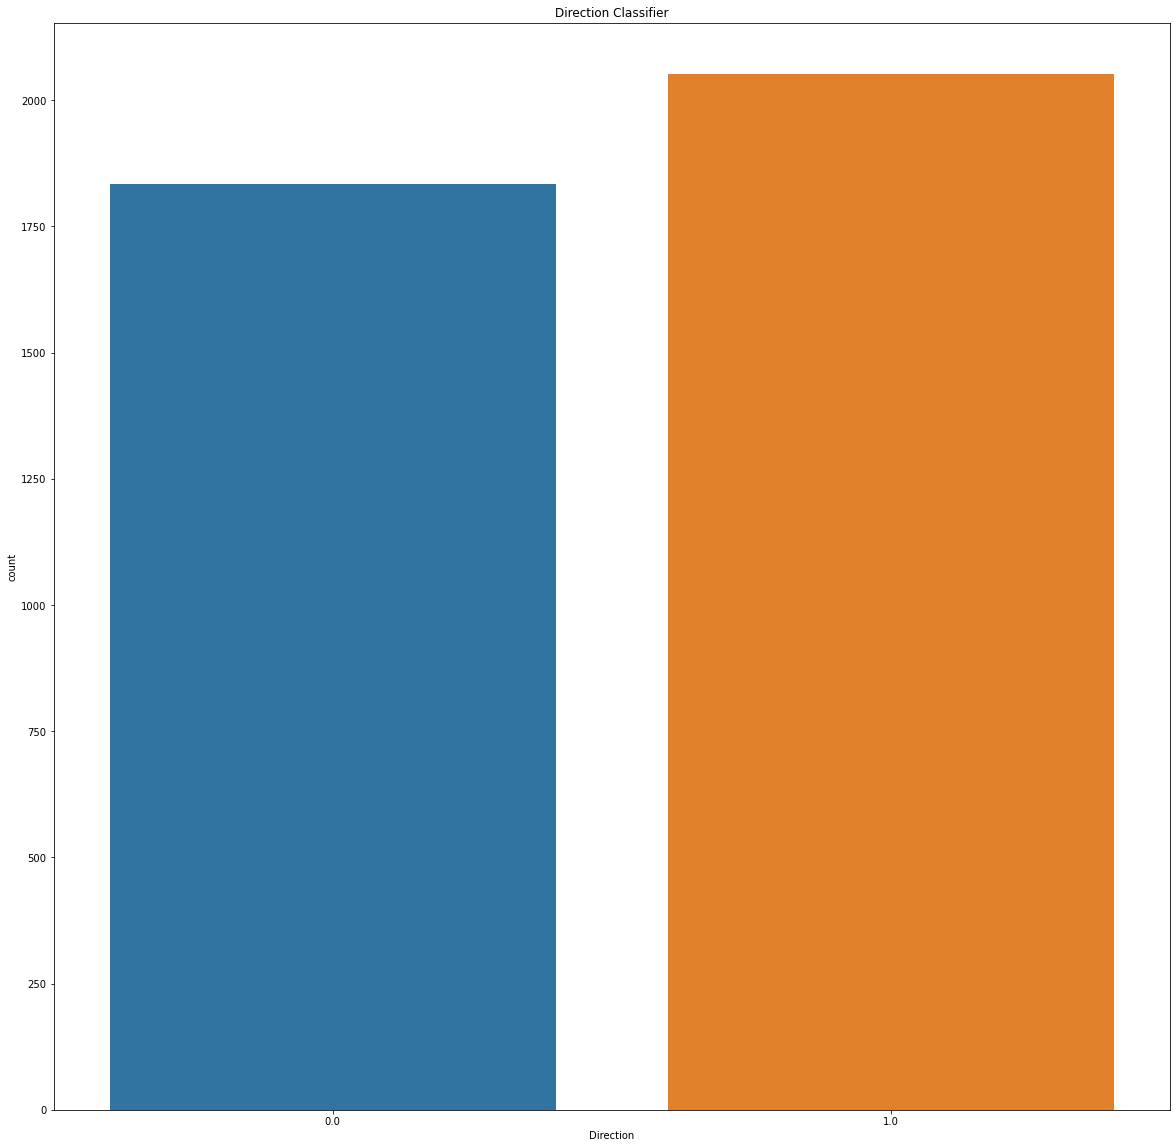

In [1284]:
# Plot the number of "up days" compared to the number of "down days"
plt.figure(figsize=(20,20))
sns.countplot(data=df, x='Direction').set_title("Direction Classifier")

In [1285]:
# Drop rows where no data exists
df.dropna(inplace=True)

Text(0, 0.5, 'correlation')

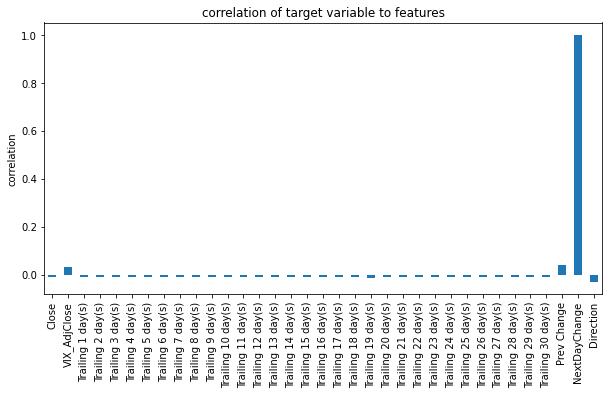

In [1286]:
# Plot correlation of the NextDayChange to current features
plt.figure(figsize=(10,5))
ax = df.corr()['NextDayChange'].plot(kind='bar',title='correlation of target variable to features')
ax.set_ylabel('correlation')

<AxesSubplot:>

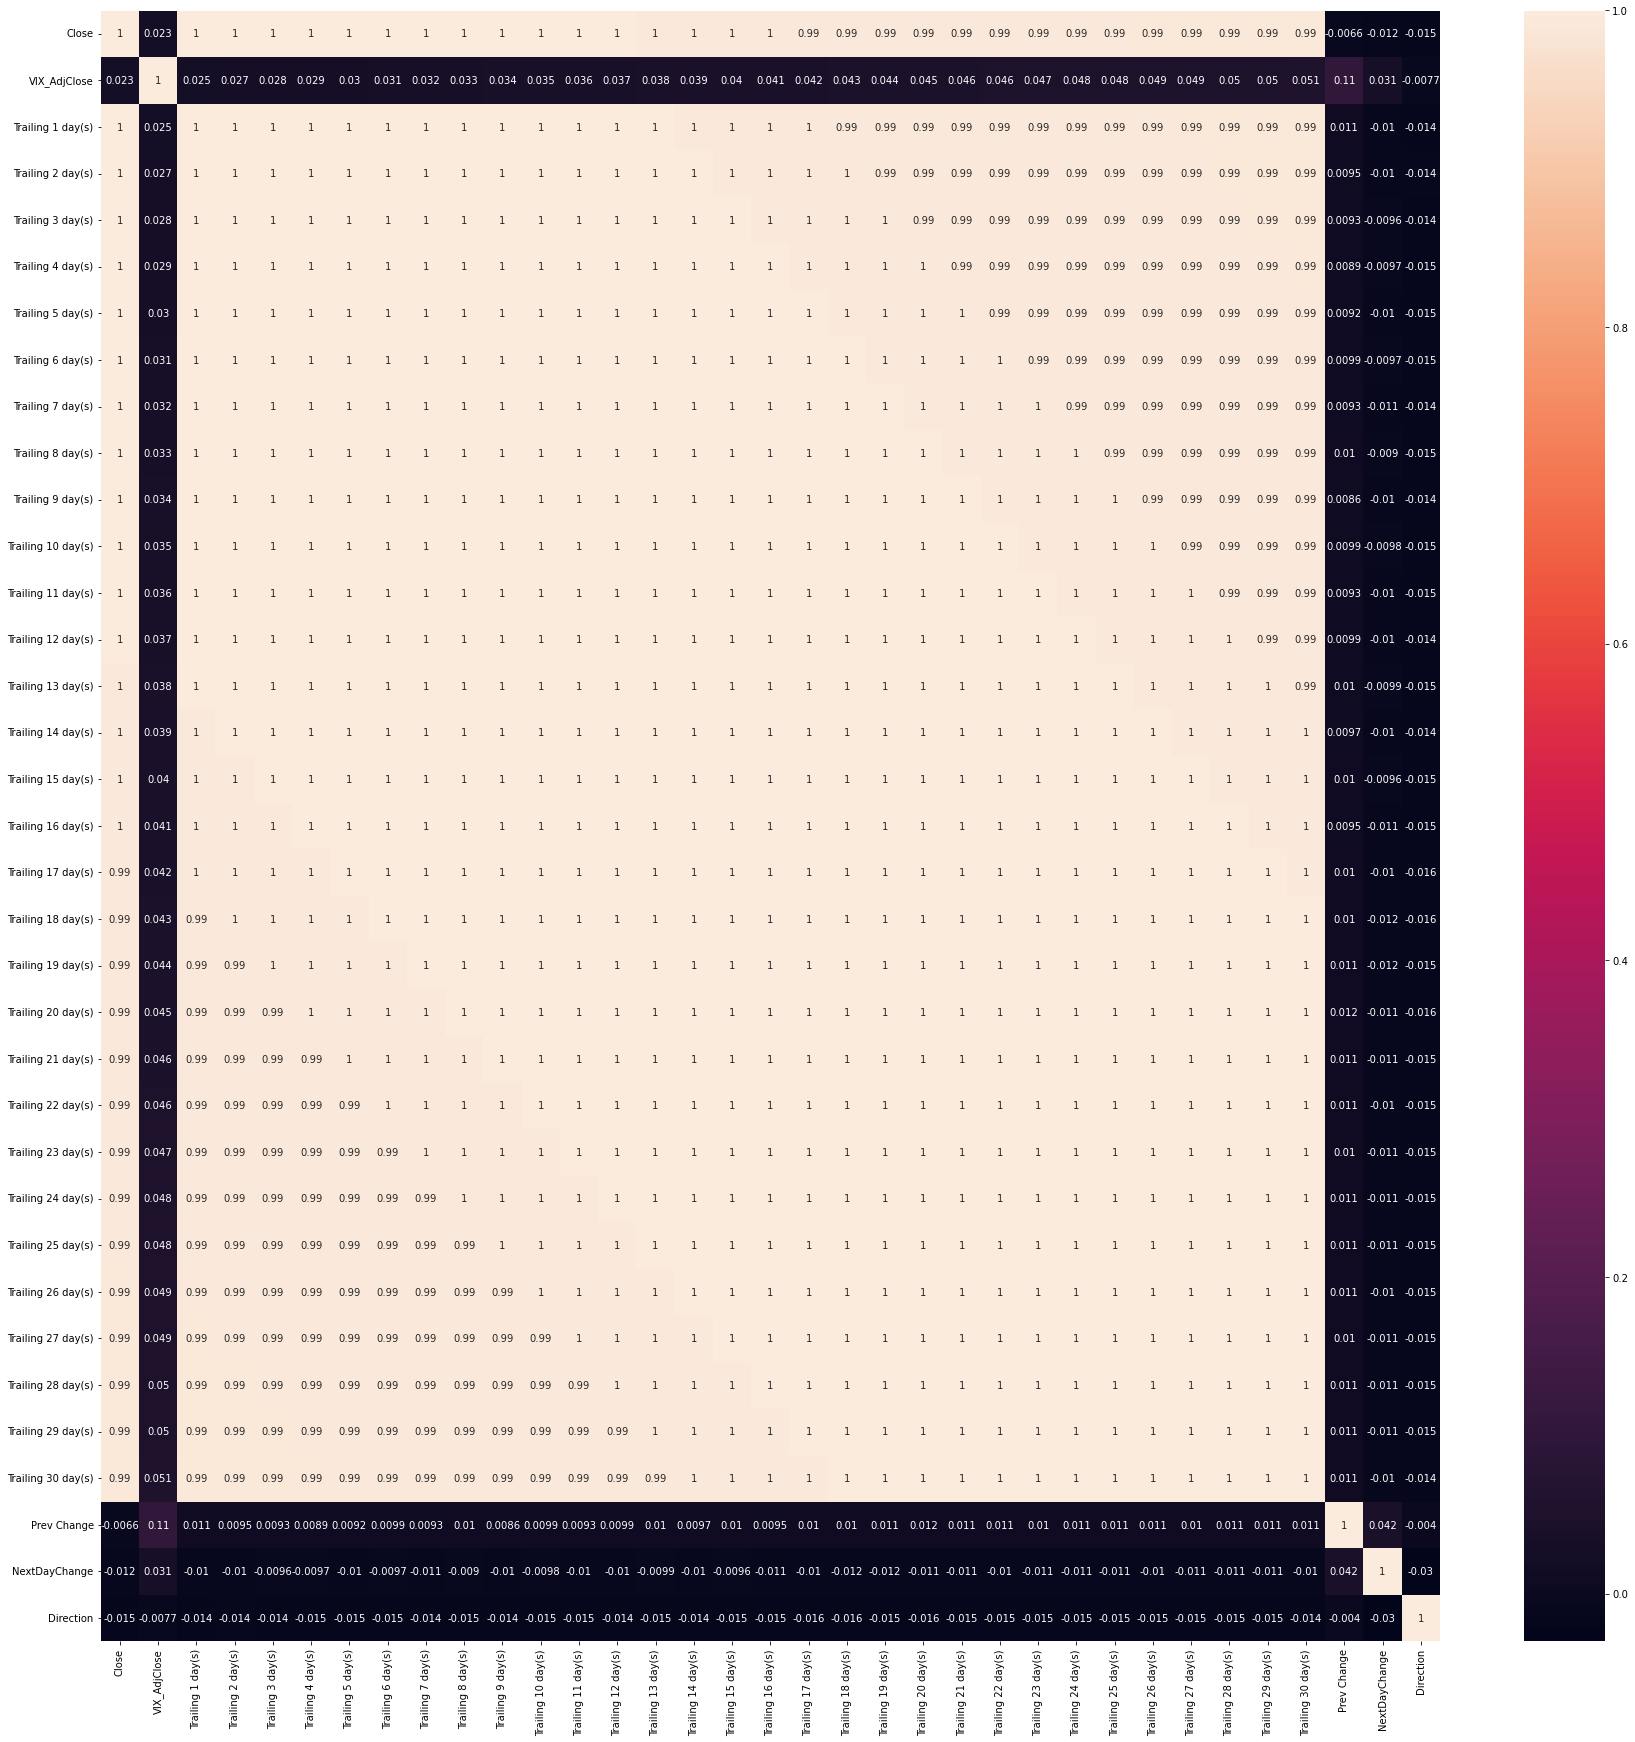

In [1287]:
plt.figure(figsize=(30, 30))
sns.heatmap(df.corr(), annot=True)

In [1288]:
# Create X and y data
# Only want to use 10 days of lagging data and vix close for inputs
X = df.drop(axis=1, columns=['Date', 'NextDayChange', 'Direction'])
# Outputs should only be direction
y = df.Direction

In [1289]:
X

,Close,VIX_AdjClose,Trailing 1 day(s),Trailing 2 day(s),Trailing 3 day(s),Trailing 4 day(s),Trailing 5 day(s),Trailing 6 day(s),Trailing 7 day(s),Trailing 8 day(s),...,Trailing 22 day(s),Trailing 23 day(s),Trailing 24 day(s),Trailing 25 day(s),Trailing 26 day(s),Trailing 27 day(s),Trailing 28 day(s),Trailing 29 day(s),Trailing 30 day(s),Prev Change
30,3.890373,26.570000,3.805436,3.847754,4.079732,4.110786,4.117483,4.013975,4.155233,4.109870,...,4.081559,4.030413,4.029198,3.967701,4.027675,4.041373,3.871499,3.691579,3.715323,-2.183245
31,3.775908,27.680000,3.890373,3.805436,3.847754,4.079732,4.110786,4.117483,4.013975,4.155233,...,4.192983,4.081559,4.030413,4.029198,3.967701,4.027675,4.041373,3.871499,3.691579,3.031443
32,3.650175,30.670000,3.775908,3.890373,3.805436,3.847754,4.079732,4.110786,4.117483,4.013975,...,4.204246,4.192983,4.081559,4.030413,4.029198,3.967701,4.027675,4.041373,3.871499,3.444592
33,3.563412,30.830000,3.650175,3.775908,3.890373,3.805436,3.847754,4.079732,4.110786,4.117483,...,4.228905,4.204246,4.192983,4.081559,4.030413,4.029198,3.967701,4.027675,4.041373,2.434820
34,3.715933,29.990000,3.563412,3.650175,3.775908,3.890373,3.805436,3.847754,4.079732,4.110786,...,4.204857,4.228905,4.204246,4.192983,4.081559,4.030413,4.029198,3.967701,4.027675,-4.104518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3879,151.070007,20.350000,150.179993,148.009995,151.289993,150.720001,148.789993,150.039993,148.279999,149.699997,...,149.202484,147.026108,143.152527,143.621750,143.511932,142.174164,138.150833,142.753204,138.110886,-0.589141
3880,148.110001,20.500000,151.070007,150.179993,148.009995,151.289993,150.720001,148.789993,150.039993,148.279999,...,152.087708,149.202484,147.026108,143.152527,143.621750,143.511932,142.174164,138.150833,142.753204,1.998519
3881,144.220001,22.209999,148.110001,151.070007,150.179993,148.009995,151.289993,150.720001,148.789993,150.039993,...,149.102661,152.087708,149.202484,147.026108,143.152527,143.621750,143.511932,142.174164,138.150833,2.697268
3882,141.169998,21.889999,144.220001,148.110001,151.070007,150.179993,148.009995,151.289993,150.720001,148.789993,...,144.560196,149.102661,152.087708,149.202484,147.026108,143.152527,143.621750,143.511932,142.174164,2.160518


In [1290]:
y

30      0.0
31      0.0
32      1.0
33      1.0
34      1.0
       ... 
3879    0.0
3880    0.0
3881    1.0
3882    1.0
3883    0.0
Name: Direction, Length: 3854, dtype: float64

In [1291]:
# Create train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=3)

In [1292]:
X_train

,Close,VIX_AdjClose,Trailing 1 day(s),Trailing 2 day(s),Trailing 3 day(s),Trailing 4 day(s),Trailing 5 day(s),Trailing 6 day(s),Trailing 7 day(s),Trailing 8 day(s),...,Trailing 22 day(s),Trailing 23 day(s),Trailing 24 day(s),Trailing 25 day(s),Trailing 26 day(s),Trailing 27 day(s),Trailing 28 day(s),Trailing 29 day(s),Trailing 30 day(s),Prev Change
3294,94.714516,24.760000,93.582169,91.822090,93.355698,91.194351,91.420837,95.780426,95.512115,96.848770,...,89.057655,87.051392,89.810928,88.634232,90.226929,88.341301,86.088905,86.583694,86.549225,-1.195537
3853,143.511932,30.500000,142.174164,138.150833,142.753204,138.110886,138.749832,140.187439,139.857986,145.189148,...,150.450424,152.117645,155.052780,153.585220,163.159332,157.109375,154.204208,155.701721,154.274078,-0.932165
403,2.847989,43.849998,2.830636,2.785883,2.743872,2.831245,2.867777,2.762139,2.728955,2.689987,...,2.762746,2.598351,2.626970,2.636710,2.612356,2.588915,2.629709,2.610227,2.739916,-0.609301
386,2.757572,42.820000,2.822111,2.770663,2.831854,2.879346,2.762746,2.598351,2.626970,2.636710,...,3.035825,2.861690,2.782840,2.919532,2.815110,2.707340,2.821198,2.892133,2.764269,2.340444
2673,37.334156,29.059999,36.883022,37.926632,38.756294,37.201569,38.154854,39.885483,39.802284,39.692932,...,41.442596,41.447350,41.601871,41.133549,40.943363,40.950493,40.230190,40.669975,40.555870,-1.208367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3030,49.919792,12.680000,49.455166,49.078110,49.438137,48.954044,48.657265,49.681400,49.725189,49.316509,...,47.239056,47.389870,46.847401,46.256271,45.056984,44.405037,43.699577,42.157303,42.587883,-0.930746
1697,17.023449,14.620000,17.096930,17.261957,17.078249,16.878069,16.745987,16.827070,16.831507,16.683907,...,16.535673,16.709558,16.636709,16.823584,17.020592,17.293633,17.230276,17.244217,16.974667,0.431643
3351,115.916115,29.350000,114.406876,117.405632,119.072708,119.546196,119.457428,122.712669,115.383446,113.410568,...,105.390831,108.843369,110.609085,113.972839,113.795273,110.480835,111.950638,115.728691,111.289734,-1.302010
1718,18.817141,13.970000,18.115568,17.983479,16.620874,16.841007,16.824219,16.626884,16.439062,16.405807,...,17.096930,17.261957,17.078249,16.878069,16.745987,16.827070,16.831507,16.683907,16.618973,-3.728369


In [1293]:
y_train

3294    1.0
3853    0.0
403     1.0
386     0.0
2673    1.0
       ... 
3030    0.0
1697    0.0
3351    0.0
1718    0.0
1928    1.0
Name: Direction, Length: 3083, dtype: float64

In [1294]:
lr = LogisticRegression(random_state = 2)
lr.fit(X_train, y_train)

C:\Users\embui\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=2)

### View test results

In [1295]:
train_accuracy = lr.score(X_train, y_train)
test_accuracy = lr.score(X_test, y_test)
print('Accuracy in Train set   : {:.2f}'.format(train_accuracy), 
      'Accuracy in Test  set   : {:.2f}'.format(test_accuracy), sep='\n')

Accuracy in Train set   : 0.54
Accuracy in Test  set   : 0.54


In [1296]:
predictions = lr.predict(X_test)

## Evaluate Results

In [1301]:
# Let's see what % of our predictions were up vs down 
num_up = np.count_nonzero(predictions)
num_down = predictions.size - np.count_nonzero(predictions)

In [1302]:
# View results
num_up

646

In [1303]:
num_down

125

Text(0, 0.5, 'Number of Predictions')

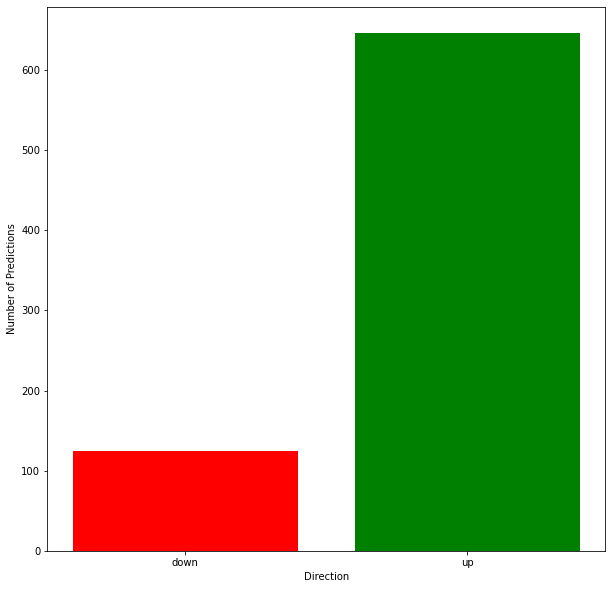

In [1310]:
percent_up = num_up / predictions.size
percent_down = num_down / predictions.size
# Plot the number of "up days" compared to the number of "down days"
plt.figure(figsize=(10,10))
plt.bar(['down', 'up'], [num_down, num_up], color=['red', 'green'])

plt.xlabel('Direction')
plt.ylabel('Number of Predictions')

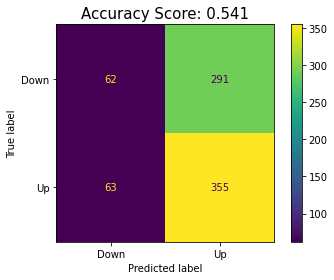

In [1311]:
# let's use a confusion matrix to easily evaluate results 
from sklearn.metrics import confusion_matrix as cm, ConfusionMatrixDisplay
score = round(accuracy_score(y_test, predictions), 3)
cm1 = cm(y_test, predictions)
confusion_matrix_obj = ConfusionMatrixDisplay(cm1, display_labels=['Down', 'Up'])
confusion_matrix_obj.plot()
plt.title('Accuracy Score: {0}'.format(score), size = 15)
plt.show()

<AxesSubplot:>

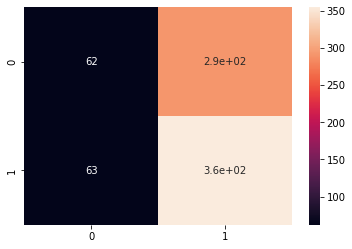

In [1298]:
import seaborn as sns
sns.heatmap(cm1, annot=True)